In [254]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import os
import logging
import time
import matplotlib.pyplot as plt

In [255]:
#os.chdir('..')
os.chdir('C:/Users/BC966HL/OneDrive - EY/4. Mestrado/Dev/')
os.getcwd()

'C:\\Users\\BC966HL\\OneDrive - EY\\4. Mestrado\\Dev'

In [256]:
#df_available_lots[['ID', 'AROMA', 'FLAVOR', 'AFTERTASTE', 'ACIDITY', 'BODY', 'BALANCE', 'MOISTURE', 'LOT_AVAILABILITY_KG', 'COST_BRL_KG']]

In [257]:
from Coding.etl.data_normalization import data_norm
from Coding.etl.input_parameters import (recipe_def, create_cost_column, input_lots, target_volume, model_files)
from Coding.model.minimize import (model_input_read, constraints_bounds, cost_obj_f, minimize_round, simulation_fixed_x0_var_iterations, simulation_var_x0_fixed_iterations, model_results)

In [258]:
# Reading CQI CSV file as input, normalizing data and creating cleaned_cqi_file.csv with no-NaN rows and consistent coffee sample parameters
data_norm()

# recipe_def function to read the cleaned_cqi_file.csv and extract a random row to be used as target for the model. It will return a single row dataframe with unusable LOT_AVAILABILITY_KG field and the normalized dataframe with the selected row removed
df_recipe, df_norm = recipe_def()

# create_cost_column gets the normalized dataframe without the recipe row and create a random cost per kg in BRL to the lot on the row, the model will seek to minimize this final cost attending to the other parameters
df_norm_cost = create_cost_column(df_norm)

# input_lots will get the normalized dataframe without the recipe row and with the cost column and extracts from the n available rows a lot_limit (default = 10) sized dataframe which will be used as available lots to the model work on
df_lots_available = input_lots(df_norm_cost, return_df_norm_wout_lots = False, lot_limit = 10)

# df_recipe_volume simulate the batch volume
# if simulate_broken_volume is set to True, it will create a volume higher than the available lots can provide together, reaching from the volume sum to broken_perc*volume sum, the broken_perc is set to 1.5 as default
# if is set to False, will get from the lots available volume sum * low_perc to volume sum * high perc, which are set as default to 0.2 and 0.8 respectively
df_recipe_volume = target_volume(df_recipe, df_lots_available, simulate_broken_volume = False)

# model_files export the recipe and available lots datasets to /Datasets/model as input_recipe.csv and input_lots_available.csv with ';' as CSV separator
model_files(df_recipe_volume, df_lots_available)

In [259]:
df_recipe, df_available_lots = model_input_read()

#constraints, bnd = constraints_bounds(df_recipe, df_available_lots, ub = 0.7)

In [260]:
#fx_x0_var_iter_round = {}
#for round in range(10):
#    fx_x0_var_iter_round[str(round)] = simulation_fixed_x0_var_iterations(df_recipe, df_available_lots, ub = 0.7, stop = 200, step = 10)

In [261]:
#test_df = pd.DataFrame(fx_x0_var_iter_round)

In [262]:
#fun_list = []
#fun_list_f = []
#nit_list = []
#nit_list_f = []
#status_list = []
#status_list_f = []
#time_list = []
#time_list_f = []

#for column in range(test_df.shape[1]):
#    for row in range(test_df.shape[0]):
#        fun_list.append(test_df[str(column)][row][0].fun)
#        nit_list.append(test_df[str(column)][row][0].nit)
#        status_list.append(test_df[str(column)][row][0].status)
#        time_list.append(test_df[str(column)][row][1]['extra_data']['round_time'])
#    fun_list_f.append(fun_list)
#    nit_list_f.append(nit_list)
#    status_list_f.append(status_list)
#    time_list_f.append(time_list)
#    fun_list = []
#    nit_list = []
#    status_list = []
#    time_list = []

#fun_df = pd.DataFrame(fun_list_f).transpose()
#fun_df['maxiter'] = test_df.index.astype(int) + 1
#nit_df = pd.DataFrame(nit_list_f).transpose()
#nit_df['maxiter'] = test_df.index.astype(int) + 1
#status_df = pd.DataFrame(status_list_f).transpose()
#status_df['maxiter'] = test_df.index.astype(int) + 1
#time_df = pd.DataFrame(time_list_f).transpose()
#time_df['maxiter'] = test_df.index.astype(int) + 1

In [263]:
#column_dict_fun = {}
#column_dict_nit = {}
#column_dict_status = {}
#column_dict_time = {}

#for columns in range(time_df.shape[1]):
#    column_dict_fun[columns] = 'fun_' + str(columns)
#    column_dict_nit[columns] = 'nit_' + str(columns)
#    column_dict_status[columns] = 'status_' + str(columns)
#    column_dict_time[columns] = 'time_' + str(columns)

#fun_df = fun_df.rename(columns = column_dict_fun)
#nit_df = nit_df.rename(columns = column_dict_nit)
#status_df = status_df.rename(columns = column_dict_status)
#time_df = time_df.rename(columns = column_dict_time)

In [264]:
#output_df = time_df.merge(how = 'inner',
#                         right = nit_df,
#                         left_on = 'maxiter',
#                         right_on = 'maxiter'
#                         ).merge(how = 'inner',
#                                 right = fun_df,
#                                 left_on = 'maxiter',
#                                 right_on = 'maxiter').merge(how = 'inner',
##                                                             right = status_df,
#                                                             left_on = 'maxiter',
#                                                             right_on = 'maxiter')

In [265]:
simulation_fx_x0_var_iter = simulation_fixed_x0_var_iterations(df_recipe, df_available_lots, ub = 0.7, stop = 500, step = 10)
simulation_var_x0_fx_iter = simulation_var_x0_fixed_iterations(df_recipe, df_available_lots, iterations = 10, model_maxiter = 100)

In [266]:
output_df = pd.DataFrame(simulation_fx_x0_var_iter).transpose()

In [267]:
output_df['maxiter'] = output_df.index.astype(int) + 1

In [268]:
nit_list = []
status_list = []
fun_list = []
time_list = []
for i in range(len(output_df['maxiter'])):
    nit_list.append(output_df[0][i].nit)
    status_list.append(output_df[0][i].status)
    fun_list.append(output_df[0][i].fun)
    time_list.append(output_df[1][i]['extra_data']['round_time'])

In [269]:
output_df['nit'] = nit_list
output_df['status'] = status_list
output_df['residuo'] = fun_list
output_df['round_time'] = time_list

In [270]:
output_success_df = output_df[output_df['status'] == 0]

In [271]:
100*len(output_success_df)/len(output_df)

82.0

In [272]:
# Grouping by output dataframe by performed number of iterations and average on numeric fields
output_df = pd.DataFrame(output_df.groupby(by = 'nit').mean())
output_success_df = pd.DataFrame(output_success_df.groupby(by = 'nit').mean())
output_df['nit'] = output_df.index
output_success_df['nit'] = output_success_df.index

Text(0, 0.5, 'Objetive function output (R$)')

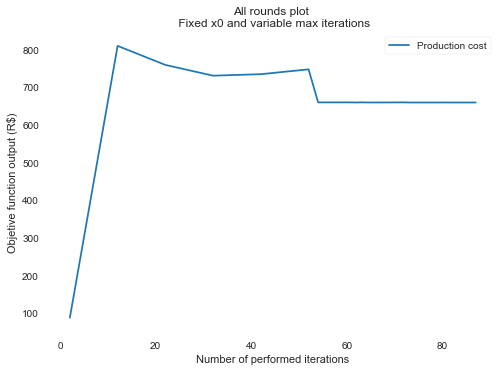

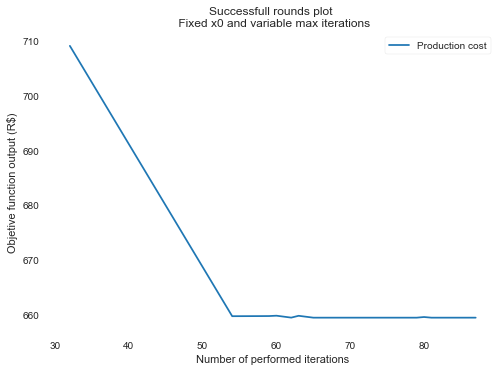

In [273]:

output_df.plot(x='nit', y=['residuo'], label=["Production cost"], kind = 'line')
plt.title('All rounds plot \n Fixed x0 and variable max iterations')
plt.xlabel('Number of performed iterations')
plt.ylabel('Objetive function output (R$)')

output_success_df.plot(x='nit', y=['residuo'], label=["Production cost"], kind = 'line')
plt.title('Successfull rounds plot \n Fixed x0 and variable max iterations')
plt.xlabel('Number of performed iterations')
plt.ylabel('Objetive function output (R$)')


Text(0, 0.5, 'Execution time (s)')

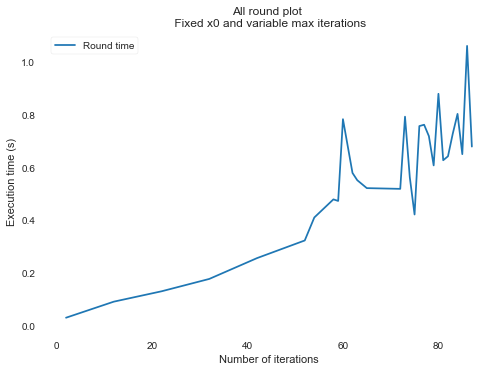

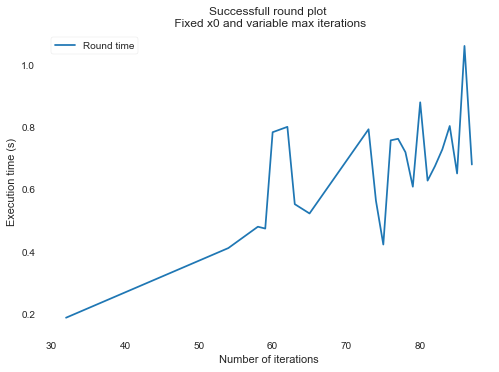

In [274]:
output_df.plot(x='nit', y=['round_time'], label=["Round time"], kind = 'line')
plt.title('All round plot \n Fixed x0 and variable max iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Execution time (s)')

output_success_df.plot(x='nit', y=['round_time'], label=["Round time"], kind = 'line')
plt.title('Successfull round plot \n Fixed x0 and variable max iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Execution time (s)')

In [278]:
simulation_fx_x0_var_iter

1191711, 0.03583527,
         0.00652313, 0.0278244 , 0.02698517, 0.01603699, 0.02446747])
   message: 'Optimization terminated successfully.'
      nfev: 995
       nit: 83
      njev: 82
    status: 0
   success: True
         x: array([4.69229176e-07, 1.00000000e+00, 1.00000000e+01, 0.00000000e+00,
         3.45176613e+03, 1.51444677e+04, 5.52666451e-08, 3.46176613e+03,
         0.00000000e+00, 5.60000000e+02]),
  {'extra_data': {'round_time': 0.841345699998783,
    'x0': array([27, 74,  8, 20, 46, 78, 63,  7, 29, 24])}}),
 '191': (     fun: 659.5095241349645
       jac: array([0.01676941, 0.00868988, 0.01169586, 0.01190948, 0.03583527,
         0.00652313, 0.0278244 , 0.02698517, 0.01603699, 0.02446747])
   message: 'Optimization terminated successfully.'
      nfev: 946
       nit: 79
      njev: 78
    status: 0
   success: True
         x: array([0.00000000e+00, 1.00000000e+00, 9.81825405e+00, 9.69337211e-18,
         3.45186286e+03, 1.51446378e+04, 5.42465936e-18, 3.46168111e+0

In [287]:
for index in simulation_fx_x0_var_iter:
    min_f = 10**10
    if simulation_fx_x0_var_iter[index][0].fun < min_f:
        min_f = simulation_fx_x0_var_iter[index][0].fun
        index_f = index

In [291]:
best_output = simulation_fx_x0_var_iter[index_f][0].x

In [306]:
df_model_recipe_output = pd.DataFrame()
df_model_recipe_output['AROMA'] = [abs(float(df_recipe['AROMA']) - (sum(np.array(df_available_lots['AROMA'])*best_output))/sum(best_output))]

df_model_recipe_output['FLAVOR'] = [abs(float(df_recipe['FLAVOR']) - (sum(np.array(df_available_lots['FLAVOR'])*best_output))/sum(best_output))]

df_model_recipe_output['AFTERTASTE'] = [abs(float(df_recipe['AFTERTASTE']) - (sum(np.array(df_available_lots['AFTERTASTE'])*best_output))/sum(best_output))]

df_model_recipe_output['ACIDITY'] = [abs(float(df_recipe['ACIDITY']) - (sum(np.array(df_available_lots['ACIDITY'])*best_output))/sum(best_output))]

df_model_recipe_output['BODY'] = [abs(float(df_recipe['BODY']) - (sum(np.array(df_available_lots['BODY'])*best_output))/sum(best_output))]

df_model_recipe_output['BALANCE'] = [abs(float(df_recipe['BALANCE']) - (sum(np.array(df_available_lots['BALANCE'])*best_output))/sum(best_output))]

df_model_recipe_output['MOISTURE'] = [abs(float(df_recipe['MOISTURE']) - (sum(np.array(df_available_lots['MOISTURE'])*best_output))/sum(best_output))]

df_model_recipe_output['VOLUME_NEED'] = sum(best_output)

In [311]:
print('Recipe parameters'),
display(df_recipe[df_model_recipe_output.columns]), 

print('Model output parameters'),
display(df_model_recipe_output.rename(columns = {'VOLUME_NEED': 'ALLOCATED_VOLUME'})),

print('Output rate between model and recipe output'),
display((100*df_model_recipe_output/df_recipe[df_model_recipe_output.columns]).rename(columns = {'VOLUME_NEED': 'ALLOCATED_VOLUME'}))

Recipe parameters


,AROMA,FLAVOR,AFTERTASTE,ACIDITY,BODY,BALANCE,MOISTURE,VOLUME_NEED
0,6.92,6.92,6.67,7.25,7.17,6.92,0.13,23820


Model output parameters


,AROMA,FLAVOR,AFTERTASTE,ACIDITY,BODY,BALANCE,MOISTURE,ALLOCATED_VOLUME
0,0.7,0.7,0.602378,0.40247,0.264284,0.526283,0.007434,22629.0


Output rate between model and recipe output


,AROMA,FLAVOR,AFTERTASTE,ACIDITY,BODY,BALANCE,MOISTURE,ALLOCATED_VOLUME
0,10.115607,10.115607,9.031159,5.551311,3.685973,7.605249,5.718677,95.0


In [318]:
df_volume_test = pd.DataFrame(best_output)
df_volume_test['LOT_AVAILABILITY_KG'] = df_available_lots['LOT_AVAILABILITY_KG']
df_volume_test = df_volume_test.rename(columns = {0: 'ALLOCATED_VOLUME'})
df_volume_test['ALLOCATION_TEST'] = [True if df_volume_test['ALLOCATED_VOLUME'][x] <= df_volume_test['LOT_AVAILABILITY_KG'][x] else False for x in range(len(df_volume_test['LOT_AVAILABILITY_KG']))]


In [319]:
df_volume_test

,ALLOCATED_VOLUME,LOT_AVAILABILITY_KG,ALLOCATION_TEST
0,202.926209,1740.0,True
1,1.000000,1.0,True
2,10.000000,10.0,True
3,103.871646,17250.0,True
4,770.526940,17250.0,True
5,11347.764507,18000.0,True
6,1415.349273,18975.0,True
7,8213.573694,17250.0,True
8,3.987732,4.0,True
9,560.000000,560.0,True


In [300]:
df_volume_test['ALLOCATION_TEST'] = [True if df_volume_test['MODEL_RESULT_ARRAY'][x] <= df_model_output['LOT_AVAILABILITY_KG'][x] else False for x in range(len(df_volume_test['LOT_AVAILABILITY_KG']))]


0.10115606936416184